<a href="https://colab.research.google.com/github/cubukcum/road_segmentation_unet/blob/main/TUSimple_Lane_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np # linear algebra
import tensorflow as tf
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import os
import cv2
import random

In [4]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/device:TPU:0', device_type='TPU'), LogicalDevice(name='/device:TPU:1', device_type='TPU'), LogicalDevice(name='/device:TPU:2', device_type='TPU'), LogicalDevice(name='/device:TPU:3', device_type='TPU'), LogicalDevice(name='/device:TPU:4', device_type='TPU'), LogicalDevice(name='/device:TPU:5', device_type='TPU'), LogicalDevice(name='/device:TPU:6', device_type='TPU'), LogicalDevice(name='/device:TPU:7', device_type='TPU')]


In [5]:
IMG_WIDTH = 720
IMG_HEIGHT = 1280
IMG_CHANNELS = 3

In [6]:
!unzip /content/drive/MyDrive/tusimple-preprocessed.zip

Streaming output truncated to the last 5000 lines.
  inflating: tusimple_preprocessed/training/frames/0313-2_37820.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37840.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37860.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37880.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37900.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37920.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37940.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37960.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_37980.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_380.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_38000.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_38020.jpg  
  inflating: tusimple_preprocessed/training/frames/0313-2_38040.jpg  
  inflating: tusimple_preprocessed/traini

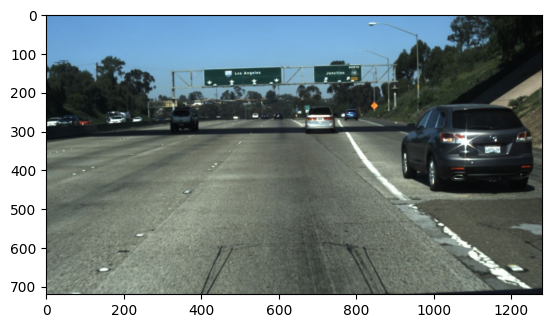

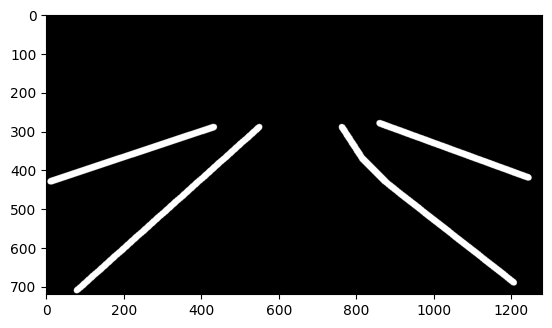

In [7]:
# TRAIN_PATH = '/content/tusimple_preprocessed/training/frames'
# TRAIN_MASKS_PATH = '/content/tusimple_preprocessed/training/lane-masks'


# train_image_files = os.listdir(TRAIN_PATH)
# train_mask_files = os.listdir(TRAIN_MASKS_PATH)


# X_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
# Y_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)



# images = []
# masks = []
# for n, image_file in enumerate(train_image_files):
#     image_path = os.path.join(TRAIN_PATH, image_file)
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# #     image = cv2.resize(image, (256,256))
#     image = image / 255

#     images.append(image)

# mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.uint8)
# for n, mask_file in enumerate(train_mask_files):
#     mask_path = os.path.join(TRAIN_MASKS_PATH, mask_file)
#     mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
# #     mask = cv2.resize(mask, (256,256))
#     mask = mask / 255.0  # Normalize to [0, 1]

#     masks.append(np.expand_dims(mask, axis=-1))


# X_train, Y_train = np.array(images), np.array(masks)
# image_x = random.randint(0, len(train_image_files))
# imshow(X_train[image_x])
# plt.show()
# imshow(Y_train[image_x])

import os
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

TRAIN_PATH = '/content/tusimple_preprocessed/training/frames'
TRAIN_MASKS_PATH = '/content/tusimple_preprocessed/training/lane-masks'
IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS = 720, 1280, 3  # Adjust dimensions as needed

train_image_files = os.listdir(TRAIN_PATH)
train_mask_files = os.listdir(TRAIN_MASKS_PATH)

X_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.float32)
Y_train = np.zeros((len(train_image_files), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.float32)

for n, image_file in enumerate(train_image_files):
    image_path = os.path.join(TRAIN_PATH, image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (IMG_WIDTH, IMG_HEIGHT))
    image = image / 255.0

    X_train[n] = image

    mask_file = train_mask_files[n]
    mask_path = os.path.join(TRAIN_MASKS_PATH, mask_file)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))
    mask = mask / 255.0

    Y_train[n] = np.expand_dims(mask, axis=-1)

# Display random example
image_x = random.randint(0, len(train_image_files) - 1)
plt.imshow(X_train[image_x])
plt.show()
plt.imshow(Y_train[image_x].squeeze(), cmap='gray')
plt.show()


In [8]:
strategy = tf.distribute.TPUStrategy(resolver)

0.0 1.0


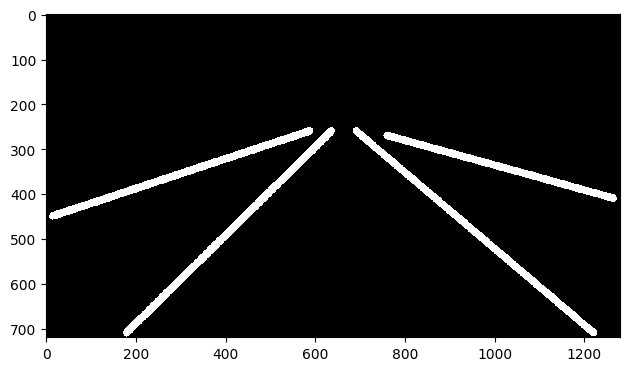

In [9]:
imshow(X_train[6])
imshow(Y_train[6])
print(np.min(Y_train), np.max(Y_train))

In [10]:
import tensorflow as tf

def create_unet_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)):
    # Build the model
    inputs = tf.keras.layers.Input(input_shape)
    s = inputs

    # Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expansive path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Create the model using the function
with strategy.scope():
    model = create_unet_model()
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss'),
        tf.keras.callbacks.TensorBoard(log_dir='logs'),
        tf.keras.callbacks.ModelCheckpoint('model_for_lane.h5', verbose=1, save_best_only=True)]

results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=8, epochs=50, callbacks=callbacks)


Epoch 1/50
408/408 [==============================] - ETA: 0s - loss: 0.1441 - accuracy: 0.9445
Epoch 1: val_loss improved from inf to 0.10771, saving model to model_for_lane.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


408/408 [==============================] - 311s 653ms/step - loss: 0.1441 - accuracy: 0.9445 - val_loss: 0.1077 - val_accuracy: 0.9551
Epoch 2/50
408/408 [==============================] - ETA: 0s - loss: 0.0746 - accuracy: 0.9607
Epoch 2: val_loss improved from 0.10771 to 0.07066, saving model to model_for_lane.h5
408/408 [==============================] - 235s 576ms/step - loss: 0.0746 - accuracy: 0.9607 - val_loss: 0.0707 - val_accuracy: 0.9622
Epoch 3/50
408/408 [==============================] - ETA: 0s - loss: 0.0628 - accuracy: 0.9635
Epoch 3: val_loss improved from 0.07066 to 0.06545, saving model to model_for_lane.h5
408/408 [==============================] - 236s 578ms/step - loss: 0.0628 - accuracy: 0.9635 - val_loss: 0.0654 - val_accuracy: 0.9633
Epoch 4/50
408/408 [==============================] - ETA: 0s - loss: 0.0574 - accuracy: 0.9648
Epoch 4: val_loss improved from 0.06545 to 0.05812, saving model to model_for_lane.h5
408/408 [==============================] - 236s 5

In [12]:
tf.saved_model.save(model,"/content/" )

In [21]:
import tensorflow as tf
#/content/drive/MyDrive
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model("/content/") # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open('/content/drive/MyDrive/model.tflite', 'wb') as f:
  f.write(tflite_model)

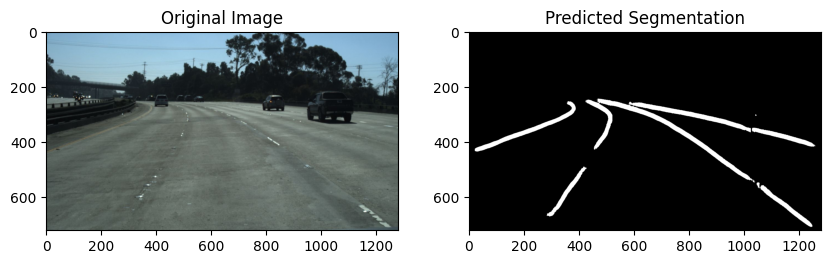

In [24]:
import numpy as np
import tensorflow as tf
from skimage.io import imread
from skimage.transform import resize
import matplotlib.pyplot as plt

# Load TFLite model and allocate tensors
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/model-tusimple.tflite")
interpreter.allocate_tensors()

# Get input and output tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Define input size based on your model
input_shape = input_details[0]['shape']
input_height, input_width = input_shape[1], input_shape[2]

# Load and preprocess the image
def preprocess_image(image_path):
    image = imread(image_path)
    image = resize(image, (input_height, input_width), mode='constant', preserve_range=True)
    image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image

# Predict function
def predict(image_path):
    image = preprocess_image(image_path)

    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()

    # Get the output tensor
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data[0]

# Postprocess and visualize the result
def visualize_prediction(image_path, prediction):
    # Load the original image for visualization
    original_image = imread(image_path)
    original_image_resized = resize(original_image, (input_height, input_width), mode='constant', preserve_range=True)
    original_image_resized = original_image_resized.astype(np.uint8)  # Convert to uint8 for display

    # Process the prediction to create a binary mask
    prediction = (prediction > 0.5).astype(np.uint8)
    prediction = np.squeeze(prediction)

    # Display the original image and the prediction
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(original_image_resized)

    plt.subplot(1, 2, 2)
    plt.title("Predicted Segmentation")
    plt.imshow(prediction, cmap='gray')

    plt.show()

# Example usage
image_path = '/content/tusimple_preprocessed/training/frames/0313-1_13720.jpg'
prediction = predict(image_path)
visualize_prediction(image_path, prediction)
